# Carga de librerías

In [1]:
import numpy as np
import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Loads an image into PIL format.
from tensorflow.keras.preprocessing import image

#Preprocesa un tensor o matriz Numpy codificando un lote de imágenes.
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Para codificaciones one-hot
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Para cargar el modelo VGG16
from tensorflow.keras.applications import VGG16

# Carga de los datos

In [2]:
root = 'dataset'

for root, dirs, files in os.walk(root):
    if len(dirs) > 0:
        categories = [os.path.join(root, x) for x in dirs if x not in []]

In [3]:
categories

['dataset\\training_set\\cats', 'dataset\\training_set\\dogs']

In [4]:
def get_image(path):
    
    # Se carga la imagen y se hace un resize, ya que es el tamaño que requiere VGG16 (224x224 RGB)
    img = image.load_img(path, target_size=(224, 224))
    
    # Se transforma a un array
    x = image.img_to_array(img)
    
    # np.expand_dims expande la forma de una matriz
    # Inserta un nuevo eje que aparecerá en la posición
    # del parámetro axis en la forma de matriz expandida.
    
    # "axis" indica la posición en los ejes expandidos 
    # donde se coloca el nuevo eje (o ejes).
    
    # Tamaño inicial de la imagen: (224, 224, 3)
    # Tamaño expandido de la imagen: (1, 224, 224, 3)    
    x = np.expand_dims(x, axis=0)
    
    #Preprocesa un tensor o matriz Numpy codificando un lote de imágenes.
    # Devuelve un numpy.array o un tf.Tensor preprocesado con tipo float32.
    x = preprocess_input(x)
    
    return img, x

Ahora cargaremos los datos del directorio:

In [5]:
# Inicializamos una lista para almacenar diccionarios imagen-categoría
data = []

# Para cada índice, categoría:
for c, category in enumerate(categories):
    
    # Inicializamos lista para almacenar las imágenes de la categoría
    images = []
    
    # Para cada root, dir intermedio (vacío), filename en la categoría
    for dp, _, filenames in os.walk(category):
        
        # Para cada nombre de imagen 
        for f in filenames:
            
            # print(os.path.splitext(f)) # Devuelve ('image_0001', '.jpg')
            # Si la extensión del archivo está bien:
            if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']:
                images.append(os.path.join(dp, f))
                
    for img_path in images:
    
        # Utilizamos ahora la función de carga definida más arriba
        img, x = get_image(img_path)

        # Creamos un diccionario para generar cada X y su target
        data.append({'x':np.array(x[0]), 'y':c})

In [6]:
num_classes = len(categories)
num_classes

2

Mezclamos los datos para darles aleatoriedad:

In [7]:
random.shuffle(data)

Y se definen las particiones de entrenamiento (train) y validación (val):

In [8]:
# Particiones de train y validation
train_split, val_split = 0.85, 0.15 # Val split: 0.15

In [9]:
# Los datos de entrenamiento se tomarán desde el principio hasta idx_val
idx_val = int(train_split * len(data))
idx_val

6800

In [10]:
len(data)

8000

In [11]:
# Los datos de entrenamiento se toman desde el principio hasta idx_val
train = data[:idx_val]

In [12]:
len(train)

6800

In [13]:
# Los datos de validación se toman desde el idx_val hasta idx_test
val = data[idx_val:]

In [14]:
len(val)

1200

Separamos ahora los datos de las etiquetas:

In [15]:
X_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]

In [16]:
X_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]

# Preprocesamiento de los datos

Preprocesaremos los datos para asegurarnos de que sean float32 y estén normalizados entre 0 y 1.

In [17]:
# Normalización
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.

In [18]:
# Conversión de etiquetas en vectores one-hot
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

Un resumen de los valores obtenidos hasta ahora:

In [19]:
print('*'*100)
print('')
print(f"Se han cargado {len(data)} imágenes de {num_classes} categorías")
print(f"Entrenamiento {len(X_train)} / Validación {len(X_val)}")
print('-'*100)
print(f"Dimensiones de las variables del subconjunto de entrenamiento: {X_train.shape}")
print(f"Dimensiones de las etiquetas de entrenamiento: {y_train.shape}")
print('-'*100)
print(f"Dimensiones de las variables del subconjunto de validación: {X_val.shape}")
print(f"Dimensiones de las etiquetas de validación: {y_val.shape}")
print('')
print('*'*100)

****************************************************************************************************

Se han cargado 8000 imágenes de 2 categorías
Entrenamiento 6800 / Validación 1200
----------------------------------------------------------------------------------------------------
Dimensiones de las variables del subconjunto de entrenamiento: (6800, 224, 224, 3)
Dimensiones de las etiquetas de entrenamiento: (6800, 2)
----------------------------------------------------------------------------------------------------
Dimensiones de las variables del subconjunto de validación: (1200, 224, 224, 3)
Dimensiones de las etiquetas de validación: (1200, 2)

****************************************************************************************************


A continuación vamos a representar una muestra aleatoria de imágenes para comprobar con qué estamos trabajando:

In [20]:
# Tomamos una muestra aleatoria de imágenes, para lo cual seleccionamos su índice
idx = [int(len(images) * random.random()) for i in range(8)]
idx

[3461, 3109, 2792, 2164, 2815, 3289, 3409, 3142]

In [21]:
# Las cargamos con keras en formato PIL
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
imgs

[<PIL.Image.Image image mode=RGB size=224x224 at 0x19D3DEDE780>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x19D4FF390B8>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x19D4FF39128>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x19D4FF39198>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x19D4FF39208>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x19D4FF39278>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x19D4FF392E8>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x19D4FF39358>]

In [22]:
# Convertimos la lista anterior en una lista de arrays de numpy
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)

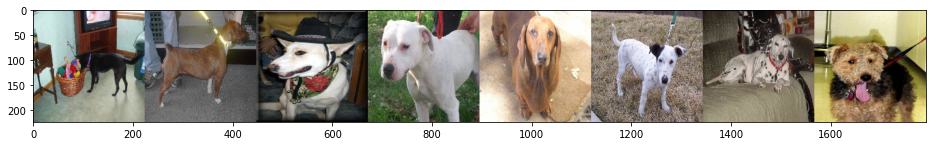

In [23]:
plt.figure(figsize=(16,4))
plt.imshow(concat_image)
plt.show()

# Transfer Learning

## Entrenando el Modelo VGG16

Instanciamos el modelo VGG16:

In [24]:
vgg = VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
# Hacemos referencia a la capa de entrada de VGG
inp = vgg.input

# Creamos una nueva capa softmax con tantas neuronas como num_classes
new_classification_layer = Dense(num_classes, activation='softmax')

# Conectamos nuestra nueva capa a la estructura copiada de VGG 
# (desde la segunda hasta la última capa de VGG), 
# y hacemos una referencia a ella
out = new_classification_layer(vgg.layers[-2].output)

# Creamos una nueva red entre inp y out
model_new = Model(inp, out)

In [26]:
# Hacemos todas las capas "no entrenables" congelando sus pesos (excepto la última)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# Nos aseguramos de que la última capa sea entrenable (no esté congelada)
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Seguidamente, se lleva a cabo el entrenamiento del nuevo modelo con todas las capas y pesos congelados exceptuando la nueva última capa:

In [27]:
history_1 = model_new.fit(X_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(X_val, y_val))

Epoch 1/10
54/54 [==============================] - 930s 17s/step - loss: 0.4898 - accuracy: 0.7790 - val_loss: 0.3324 - val_accuracy: 0.8683
Epoch 2/10
54/54 [==============================] - 941s 17s/step - loss: 0.3090 - accuracy: 0.8771 - val_loss: 0.2710 - val_accuracy: 0.8983
Epoch 3/10
54/54 [==============================] - 707s 13s/step - loss: 0.2629 - accuracy: 0.8946 - val_loss: 0.2503 - val_accuracy: 0.8925
Epoch 4/10
54/54 [==============================] - 881s 16s/step - loss: 0.2436 - accuracy: 0.8999 - val_loss: 0.2363 - val_accuracy: 0.8950
Epoch 5/10
54/54 [==============================] - 949s 18s/step - loss: 0.2354 - accuracy: 0.9010 - val_loss: 0.2237 - val_accuracy: 0.9208
Epoch 6/10
54/54 [==============================] - 830s 15s/step - loss: 0.2182 - accuracy: 0.9121 - val_loss: 0.2271 - val_accuracy: 0.9150
Epoch 7/10
54/54 [==============================] - 958s 18s/step - loss: 0.2093 - accuracy: 0.9147 - val_loss: 0.2819 - val_accuracy: 0.8658
Epoch 

A continuación, se representan los valores de la función de coste y precisión para los datos de validación:

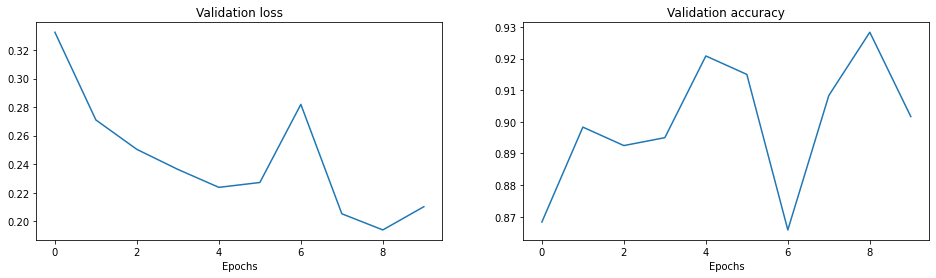

In [28]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history_1.history["val_loss"])
ax.set_title("Validation loss")
ax.set_xlabel("Epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history_1.history["val_accuracy"])
ax2.set_title("Validation accuracy")
ax2.set_xlabel("Epochs")
plt.show()

Atendiendo a las gráficas, se comprueba que la pérdida de validación presenta valores irregulares aunque con una tendencia a la reducción en todo momento. Sin embargo, se observa que comienza a aumentar justo a partir de la octava epoch; además, se comprueba que la precisión de la validación comienza a reducirse por debajo del 90% a partir de la misma época.

Esto sugiere que nuestro modelo comienza a sobreajustarse en ese punto y que el mejor rendimiento se alcanza deteniendo el entrenamiento antes. El óptimo se conseguiría, por tanto, realizándose 8 epochs.

En general, aplicando Transfer-Learning se obtiene una precisión superior al 90% tanto en los datos de entrenamiento como los de validación.

## Predicciones

Cargamos los datos de test:

In [29]:
root = 'test_set'

for root, dirs, files in os.walk(root):
    if len(dirs) > 0:
        categories_test = [os.path.join(root, x) for x in dirs if x not in []]

In [30]:
categories_test

['test_set\\cats', 'test_set\\dogs']

In [31]:
data_test = []

for c, category in enumerate(categories_test):
    
    images_test = []
    
    for dp, _, filenames in os.walk(category):
        
        for f in filenames:
            
            if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']:
                images_test.append(os.path.join(dp, f))
                
    for img_path_test in images_test:
    
        img, x = get_image(img_path_test)
        data_test.append({'x':np.array(x[0]), 'y':c})

Mezclamos los datos para darles aleatoriedad:

In [32]:
random.shuffle(data_test)

Y separamos de nuevo los datos de las etiquetas, al igual que hicimos con los datos de entrenamiento:

In [33]:
X_test, y_test = np.array([t["x"] for t in data_test]), [t["y"] for t in data_test]
print(y_test)

[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 

Comprobamos que se han cargado correctamente las etiquetas de las 2000 imágenes del conjunto de test:

In [34]:
len(y_test)

2000

Normalizamos los datos y realizamos la conversión one-hot para las etiquetas:

In [35]:
X_test = X_test.astype('float32') / 255.
y_test = to_categorical(y_test, num_classes)
print(y_test.shape)

(2000, 2)


A modo de resumen:

In [36]:
print('*'*100)
print('')
print(f"Se han cargado {len(data_test)} imágenes de {num_classes} categorías")
print('-'*100)
print(f"Dimensiones de las variables del subconjunto de test: {X_test.shape}")
print(f"Dimensiones de las etiquetas de test: {y_test.shape}")
print('')
print('*'*100)

****************************************************************************************************

Se han cargado 2000 imágenes de 2 categorías
----------------------------------------------------------------------------------------------------
Dimensiones de las variables del subconjunto de test: (2000, 224, 224, 3)
Dimensiones de las etiquetas de test: (2000, 2)

****************************************************************************************************


Por último, realizaremos una valoración del modelo en base a sus predicciones:

In [37]:
loss, accuracy = model_new.evaluate(X_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.23444706201553345
Test accuracy: 0.8930000066757202


Obteniéndose unos valores similares a los conseguidos durante el entrenamiento.

Si se quisiera predecir una imagen:

In [38]:
img, x = get_image('test_set/cats/cat.4014.jpg')
pred = model_new.predict([x])

In [39]:
pred.max()

1.0

In [40]:
pred.argmax()

0

In [41]:
categories_test[0]

'test_set\\cats'

Para el caso particular de la imagen cat.4014.jpg, el modelo predice con un acierto del 100% que la figura se corresponde con la categoría de gato.